## Final Project Submission

Please fill out:
* Student names: Brian Reynolds, Timi, Elijah 
* Student pace: full time
* Scheduled project review date/time: January 28, 2022 @ 13:00 EST
* Instructor name: Angela Spratley
* Blog post URL:



---


# Microsoft Film Studios
## A venture proposal

### Overview

This project analyzes the direction Microsoft should take when considering creating a film studio to enter into the cinema and movies market. Cursory analysis of film subjects show that movie genre and budget play a significant role in audience reception and gross revenue. Microsoft can use this analysis when considering movie subjects to proceed with and create actionable plans for movie development and growth in the film industry.

### Business Problem

Microsoft may be interested in expanding their financial portfolio into the film industry. When considering a large set of categories to enter in on, Microsoft may be able to make profit following popular genre trends. Using the [Internet Movie Database](https://www.imdb.com/) (IMDb), [The Numbers](https://www.the-numbers.com/) (TNDb), and [The Movie Database](https://www.themoviedb.org/) (TMDb) databases, we describe recent (2015-2019) film popularity trends and their gross revenues to better understand the business environment the new film studio will be entering.

### Data Understanding

IMDb, TNDb, and TMDb are data giants in the film industry, aggregating data from domestic and international film markets. These databases and files provide movie titles, release dates and years, production budgets, domestic and worldwide gross revenue, and inferential user statistics such as votes, ratings and popularity.

In [2]:
# Import packages
import pandas as pd
import seaborn as sns
import sqlite3 as sq
import matplotlib.pyplot as plt
%matplotlib inline

# Add extra relevant packages below as needed: 
import shutil
import numpy as np
import os
import re

#### Aggregating Databases

Databases are called and relevant columns are placed into a dataframe.   
Data cleaning occurs before a new data set is added to the master dataframe, removing null value entries and entries with release dates prior to 2015. Fiscal values are stripped of extra characters and turned into integers for numeric analysis.

Database files are then closed and temporary working files removed.

In [3]:
# Import TMDB Database and format
db = pd.read_csv('zippedData/tmdb.movies.csv.gz')
db['genre_ids'].replace([''], np.nan, inplace=True)

#Import TN Database
tn_budget_raw = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#Combine TN and TMDB databases
result = pd.merge(tn_budget_raw, db, left_on='movie', right_on='original_title',how='inner')
result.drop(columns=['id_x','Unnamed: 0','genre_ids','id_y','original_title','title'], inplace=True)

# Unzip IMDB SQL to new folder repository
import zipfile
with zipfile.ZipFile("zippedData/im.db.zip", 'r') as zip_ref:
    zip_ref.extractall("temp/IMDB_sql")
    
db_file = 'temp/IMDB_sql/im.db'

# Initializing imdb SQL database
# Create a SQL connection to our SQLite database
con = sq.connect(db_file)


## Query database for relevant information
genre_reviews = pd.read_sql(""" SELECT genres, primary_title, start_year
                
                FROM movie_basics
                LEFT JOIN movie_ratings ON movie_ratings.movie_id = movie_basics.movie_id
                JOIN movie_akas ON movie_akas.movie_id = movie_basics.movie_id
                WHERE start_year >= 2015 and region = 'US'
                ORDER BY averagerating DESC

""", con)

# Remove NaN values from SQL database
genre_reviews.dropna(inplace = True)

# Combine CSV and SQL data and format
comb_data = pd.merge(result, genre_reviews, left_on='movie', right_on='primary_title',how='inner')
comb_data.drop(columns=['primary_title', 'release_date_x','release_date_y'], inplace=True)
comb_data.drop_duplicates(subset=['movie'], inplace=True, ignore_index=True)

# Convert production budgets into ints
comb_data['production_budget'] = comb_data['production_budget'].str.strip('$')
comb_data['production_budget'] = comb_data['production_budget'].str.replace(',','')
comb_data['production_budget'] = comb_data['production_budget'].astype(int)

#Convert domestic gross into ints
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.strip('$')
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.replace(',','')
comb_data['domestic_gross'] = comb_data['domestic_gross'].astype(int)

# Convert worldwide gross into ints
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.strip('$')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.replace(',','')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].astype(int)

# Removing movies that made less than $25,000
comb_data = comb_data[(comb_data['worldwide_gross'] > 25000)]

#remove temporary files
con.close()
shutil.rmtree('temp/')

# Print master data frame
comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year
0,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015
1,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018
2,Justice League,300000000,229024295,655945209,en,34.953,6.2,7510,"Action,Adventure,Fantasy",2017
3,Spectre,300000000,200074175,879620923,en,30.318,6.4,6719,"Action,Adventure,Thriller",2015
4,Solo: A Star Wars Story,275000000,213767512,393151347,en,29.502,6.6,3838,"Action,Adventure,Fantasy",2018
...,...,...,...,...,...,...,...,...,...,...
643,The Fits,170000,166425,169242,en,4.938,6.6,66,"Drama,Music",2015
644,The Gallows,100000,22764410,41656474,en,9.166,4.8,591,"Horror,Mystery,Thriller",2015
645,A Ghost Story,100000,1594798,2769782,en,11.886,7.0,906,"Drama,Fantasy,Romance",2017
650,Krisha,30000,144822,144822,en,0.600,9.0,1,Drama,2015


#### Feature engineering

Created a new dataframe, sorting out genre combinations with count values less than 15. This removes a good amount of junk data as well as rare genre combinations, giving us a better interpretation of what is common in the current market scheme.

We added an `international_gross` column for analysis by subtracting the `domestic_gross` from the `worldwide_gross`.

In [4]:
# Create new df with genre counts higher than n
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) >= 15]

df1['international_gross'] = df1.worldwide_gross - df1.domestic_gross

# Print df1
df1

C:\Users\bjere\AppData\Local\Temp/ipykernel_66856/2968766825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['international_gross'] = df1.worldwide_gross - df1.domestic_gross


,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,international_gross
0,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015,944008095
1,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1369318718
2,Justice League,300000000,229024295,655945209,en,34.953,6.2,7510,"Action,Adventure,Fantasy",2017,426920914
4,Solo: A Star Wars Story,275000000,213767512,393151347,en,29.502,6.6,3838,"Action,Adventure,Fantasy",2018,179383835
5,Captain America: Civil War,250000000,408084349,1140069413,en,39.137,7.4,14000,"Action,Adventure,Sci-Fi",2016,731985064
...,...,...,...,...,...,...,...,...,...,...,...
600,Road Hard,1500000,113169,113169,en,1.080,6.6,12,Comedy,2015,0
621,Columbus,700000,1017107,1110511,en,8.964,7.3,130,Drama,2017,93404
644,The Gallows,100000,22764410,41656474,en,9.166,4.8,591,"Horror,Mystery,Thriller",2015,18892064
650,Krisha,30000,144822,144822,en,0.600,9.0,1,Drama,2015,0


In [5]:
def get_genre_avg(genre, metric):
    '''
    This function takes in a genre and a metric as defined by the dataframe
    columns and returns a statistical mean of that metric for the given genre.
    '''
    df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
    df2 = df1[(df1[genre+"_count"] == 1)]
    df2_avg = df2[metric].mean()
    df1.drop(columns=[genre+"_count"], inplace=True)
    return df2_avg

#### Mean Domestic and International Gross by Genre

Here, we extract gross revenue data from the filtered dataframe `df1` to create a stacked bar graph with both domestic and international gross revenue averages by movie genre.

In [6]:
# Set dataframe
genres = ['Action','Adventure','Animation','Comedy','Crime','Drama','Fantasy','Horror','Mystery','Sci-Fi','Thriller']
int_gross_genre = []
for i in genres:
    int_gross_genre.append(get_genre_avg(i,'international_gross'))
    
dom_gross_genre = []
for i in genres:
    dom_gross_genre.append(get_genre_avg(i,'domestic_gross'))

dic = {'Genre': genres,
      'International Gross' : int_gross_genre,
      'Domestic Gross' : dom_gross_genre}

df = pd.DataFrame(dic)

C:\Users\bjere\AppData\Local\Temp/ipykernel_66856/543476926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
C:\Users\bjere\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
# Sort df by sum of gross revenue
df['total_gross'] = df['International Gross'] + df['Domestic Gross'] 
df_sort = df.sort_values('total_gross', ascending=False, ignore_index=True)
df_sort.drop(columns=['total_gross'], inplace=True)
df = df_sort

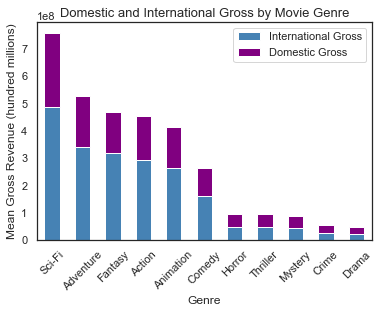

In [8]:
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
df.set_index('Genre').plot(kind='bar', stacked=True, color=['steelblue', 'purple'])

#add overall title
plt.title('Domestic and International Gross by Movie Genre', fontsize=13)

#add axis titles
plt.xlabel('Genre')
plt.ylabel('Mean Gross Revenue (hundred millions)')

#remove scientific notation
plt.ticklabel_format(style='scientific', axis='y')
#plt.yticks(ax.get_yticks()//1000000)

#rotate x-axis labels
plt.xticks(rotation=45);

plt.savefig("./images/gross_rev_genre.png", dpi=150)

#### Mean Popularity Score by Genre

The popularity score is a TMDb dynamic activity metric based off user activity on TMDb. It includes hits on page view, votes, and other user interactions by day compared with the previous days' activity. It's a complicated model, but it shows a better picture of audience interest than votes or ratings alone.

In [9]:
# Populating list of averages by genre for graphing
pop_genre = []
for i in genres:
    pop_genre.append(get_genre_avg(i,'popularity'))

C:\Users\bjere\AppData\Local\Temp/ipykernel_66856/543476926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)


In [10]:
# Sort by Pop Score
df_pop = pd.DataFrame({"Genre" : genres,
                   "Popularity" : pop_genre})
df_pop.sort_values("Popularity", inplace=True, ignore_index=True, ascending=False)

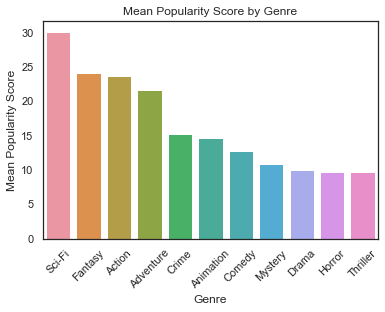

In [11]:
# Plot the graph
ax = sns.barplot(x="Genre", y="Popularity", data = df_pop)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_ylabel('Mean Popularity Score')
ax.set_title('Mean Popularity Score by Genre');

plt.savefig("./images/pop_score_genre.png", dpi=150)

#### Regression of Worldwide Gross and Production Budget

After a look at the regression coefficients for different dataframe elements, we decided to create a regression line for the most prominent factor for worldwide gross revenue from the filtered `df1` dataframe. The production budget.

In [12]:
comb_data.corr()

,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,vote_count,start_year
production_budget,1.000000,0.701904,0.773897,0.576063,0.082629,0.609798,0.055277
domestic_gross,0.701904,1.000000,0.946660,0.505589,0.191072,0.684674,0.075827
worldwide_gross,0.773897,0.946660,1.000000,0.571057,0.189167,0.724207,0.077777
popularity,0.576063,0.505589,0.571057,1.000000,0.262210,0.678333,0.302575
vote_average,0.082629,0.191072,0.189167,0.262210,1.000000,0.324905,0.029276
vote_count,0.609798,0.684674,0.724207,0.678333,0.324905,1.000000,-0.031380
start_year,0.055277,0.075827,0.077777,0.302575,0.029276,-0.031380,1.000000


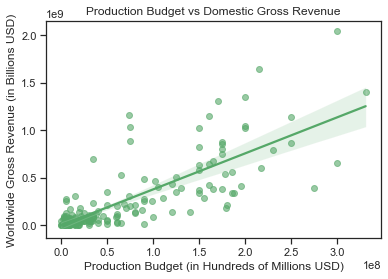

In [13]:
# Loading regression graph
sns.set_style("ticks")
pvw = sns.regplot(x=df1['production_budget'], y=df1['worldwide_gross'],
                  data=df1, scatter_kws={'alpha':0.6 },
                 color="g", )
pvw.set(
    title="Production Budget vs Domestic Gross Revenue",
    xlabel ="Production Budget (in Hundreds of Millions USD)",
    ylabel ="Worldwide Gross Revenue (in Billions USD)",
    )
sns.set_style("whitegrid")

# Saving regression graph to file
plt.savefig("./images/rev_budget_regression.png", dpi=150)

## Conclusions

This analysis suggests a few things about the current film industry:

* **Audiences are primarily interested in Sci-fi, Fantasy, Action, and Adventure films.** While other genres of films may do well fiscally, the popularity trends towards a specific set of genre and their combinations. This is likely do to the recent surge in superhero movies with Walt Disney's acquisition of Marvel in 2015.  

* **Sci-fi, Fantasy, Action, and Adventure films gross highest on average since 2015.** Entering into the film industry incurs a lot of up front costs. Microsoft should consider average gross and popularity when choosing a genre to enter on, rather then looking at net profit or return on investment which may lead to decisions that are unpopular with the target audience.   

* **High production budget means high gross revenue.** While some grossing movies do abnormally well or poor, there is a general trend for well funded movies to do well in the box office when considering both domestic and international markets.  



### Next Steps

Further analyses could yield additional insight into other industry details:

* **Popularity is a dynamic metric that needs to be followed.** The popularity of any genre may change frequently with audience decisions and interests. Using popularity data to guage and predict future interest of audiences can give Microsoft Film Studios an edge in this highly competitive industry. Focus groups may add to this insight.

* **Analysis of effective production crews and writers is needed.** Cast and crew are important parts of both popularity vote and the creative process behind film production.

* **Time of release may effect box office gross.** Analysis of seasonal or monthly releases may provide insight to audience behavior in the film industry. Competitor behavior may also play a role in box office gross with pending releases of competing titles.